In [1]:
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# add ....RealSeries/realseries to sys path. 
# if import error, modify '..' to your own absolute path
sys.path.append('..')

In [3]:
from realseries.models.rnn import LSTMED
from realseries.utils.evaluation import point_metrics, adjust_predicts,adjust_metrics
from realseries.utils.data import load_split_NASA, load_splitted_RNN, load_NAB
from realseries.utils.visualize import plot_anom,plot_mne
warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

In [4]:
# load and split data
# ----------------------------
dirname = 'realKnownCause'
filename = 'nyc_taxi.csv'

# the fraction of used for test
fraction = 0.5
train_set, test_set = load_NAB(dirname, filename, fraction=fraction)

load data from /mnt/mfs/zhangxianrui/code/RealSeries/examples/data/NAB_data/realKnownCause/nyc_taxi.csv


<Figure size 432x288 with 0 Axes>

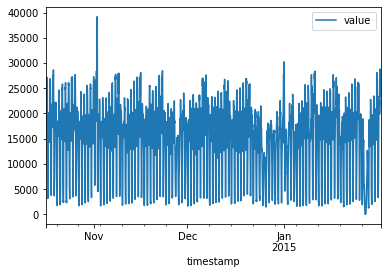

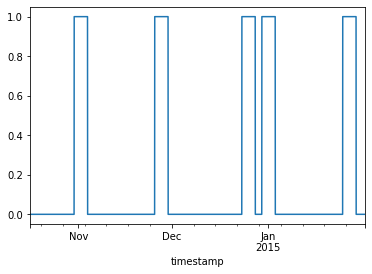

In [5]:
# plot data and label
train_data, train_label = train_set.iloc[:, :-1], train_set.iloc[:, -1]
test_data, test_label = test_set.iloc[:, :-1], test_set.iloc[:, -1]
plt.figure()
test_data.plot()
plt.figure()
test_label.plot()

Creating RawArray with float64 data, n_channels=2, n_times=5160
    Range : 0 ... 5159 =      0.000 ...  5159.000 secs
Ready.


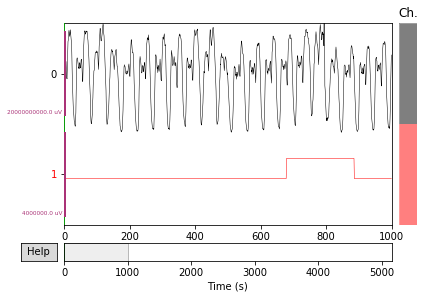

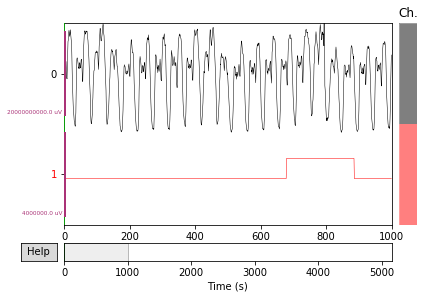

In [27]:
scalings = {'eeg': 1e4, 'ecg': 2}
color=dict(eeg='k', ecg='r')
ch_types=['eeg','ecg']

plot_mne(test_set,
        scalings=scalings,
        ch_types=ch_types,
        color=color)

In [6]:
# train parameters
# ---------------------
# path to save or load trained model (if just detect)
model_path = Path('../snapshot/lstm_ed2', filename[:-4])
print('lstm_ed model path: {:}'.format(model_path))

# number of training epochs
epochs=60

#random seed for numpy and torch
seed=1111

#batch size of training lstm input
batch_size=256

lstm_ed model path: ../snapshot/lstm_ed2/nyc_taxi


In [7]:
# fit and detect
lstm = LSTMED(epochs=epochs, 
            seed=seed, 
            batch_size=batch_size,
            model_path=model_path)

# here we just use trained model
# lstm.fit(train_data, train_label, augment_length=50000)

#detect on test_data
score = lstm.detect(test_data)

loading ../snapshot/lstm_ed2/nyc_taxi/checkpoint.pt


precision:0.9999999833333336, recall:0.005797101448715256, f1:0.011527376373305524, tp:6, tn:4125, fp:0, fn:1029


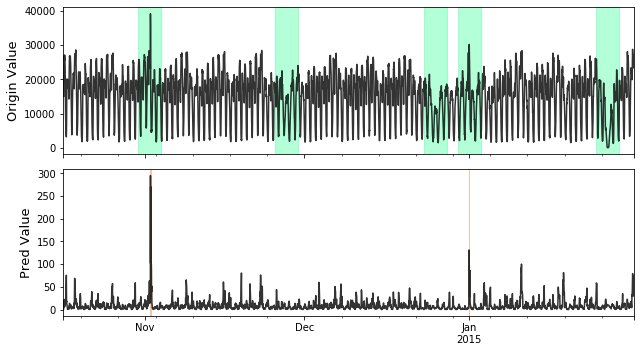

In [8]:
# the score value at the 99.9% quantile is thres
thres_percent=99.9
thres = np.percentile(score,thres_percent)
pred_label = (score>thres)
plot_anom(
    test_set,
    pred_label,
    score)
precision, recall, f1, tp, tn, fp, fn = point_metrics(pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))

precision:0.9999999997584541, recall:0.3999999999613526, f1:0.5714285305333756, tp:414, tn:4125, fp:0, fn:621


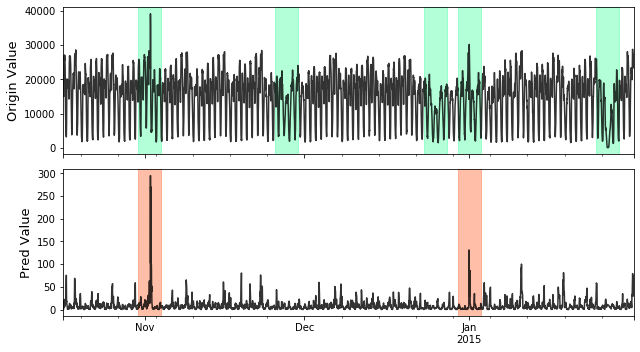

In [9]:
# adjust the pred_label for better visualization
adjust_pred_label = adjust_predicts(pred_label,test_label,delay=200)
plot_anom(
    test_set,
    adjust_pred_label,
    score)
precision, recall, f1, tp, tn, fp, fn = point_metrics(adjust_pred_label,test_label)
print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(precision, recall, f1, tp, tn, fp, fn))